# Error propagation - Cpx-only
- This notebook gives a worked example showing how to propagate uncertainty for Cpx-only thermometry for different amounts of EPMA-based error on Na$_2$O measurements.
- We use the functionality provided by Pyrolite to contour the results from Monte Carlo simulations, as well as hexplot.
- If you use the pyroplot.density command, please remember to cite Pyrolite! (Williams et al., (2020). pyrolite: Python for geochemistry. Journal of Open Source Software, 5(50), 2314, doi: 10.21105/joss.02314)
- This builds on from the notebook showing how to consider error in a single phase (Liquid_Thermometry_error_prop.ipynb). We suggest you look at that first, as its simpler when you don't have to worry about two separate phases
- We consider an example Cpx composition from Gleeson et al. (2020) - https://doi.org/10.1093/petrology/egaa094
- You can download the Excel spreadsheet here: https://github.com/PennyWieser/Thermobar/blob/main/docs/Examples/Error_propagation/Gleeson2020_Cpx_Comps.xlsx

### You need to install Thermobar once on your machine, if you haven't done this yet, uncomment the line below (remove the #)

In [1]:
#!pip install Thermobar

### You will also need to install pyrolite for this example, if you haven't done so already, uncomment the line below

In [2]:
#!pip install pyrolite

In [3]:
# Import other python stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Thermobar as pt
import sympy as sym
pd.options.display.max_columns = None
import pyrolite

## Importing data
- Note, we haven't bothered to add the "_Cpx" names after each oxide, so we simply use "suffix="_Cpx" when we load the data

In [4]:
out=pt.import_excel('Gleeson2020_Cpx_Comps.xlsx', sheet_name="Sheet1", suffix="_Cpx")
my_input=out['my_input']
myCpxs1=out['Cpxs']

## Lets select 1 Cpx to run the calculations on
- The [[ ]] keeps it as a dataframe

In [5]:
myCpxs1.iloc[[0]]

,SiO2_Cpx,TiO2_Cpx,Al2O3_Cpx,FeOt_Cpx,MnO_Cpx,MgO_Cpx,CaO_Cpx,Na2O_Cpx,K2O_Cpx,Cr2O3_Cpx,Sample_ID_Cpx
0,51.3863,0.467,4.1961,3.8654,0.12,16.3137,21.3039,0.378,0.0007,1.0191,0


## Work out errors
- The Cameca software used to analyse these Cpxs returns the error as absolute elemental wt%, ignoring Oxygen, for each element (helpful!). These are loaded in as Na_Err, Si_Err....
- This means that you need to do some steps to work out the analytical error on each Cpx. We show these steps below.
- First, we decide it easiest to use the convert_oxide_percent_to_element_weight_percent function
to convert measured Cpx compositions as oxides into wt% to compare to these errors. Without oxygen = True, does the calculations without oxygen. You can use this function for any phase, just specify what suffix your phase has.


In [6]:
Cpx_conv=pt.convert_oxide_percent_to_element_weight_percent(df=myCpxs1, suffix='_Cpx', without_oxygen=True)
Cpx_conv.head()

,Si_wt_noO2,Mg_wt_noO2,Fe_wt_noO2,Ca_wt_noO2,Al_wt_noO2,Na_wt_noO2,K_wt_noO2,Mn_wt_noO2,Ti_wt_noO2,Cr_wt_noO2,P_wt_noO2,F_wt_noO2,H_wt_noO2,Cl_wt_noO2,O_wt_make_to_100_noO2
0,43.155184,17.675115,5.398069,27.354400,3.989980,0.503819,0.001044,0.166972,0.502666,1.252750,0.0,0.0,0.0,0.0,79.664514
1,42.432683,17.004438,5.468846,27.558497,4.967044,0.507369,0.000447,0.121440,0.625890,1.313346,0.0,0.0,0.0,0.0,79.411670
2,42.399838,16.694183,5.608834,27.398388,5.209677,0.523472,0.022141,0.141541,0.681296,1.320631,0.0,0.0,0.0,0.0,79.001446
3,42.649103,17.224819,5.638033,27.496627,4.631102,0.538772,0.004336,0.097927,0.632681,1.086601,0.0,0.0,0.0,0.0,80.120961
4,41.057438,15.479289,7.324030,26.604851,6.874709,0.702197,0.025343,0.188588,1.005908,0.737648,0.0,0.0,0.0,0.0,78.524986


- Now we calculate the % error for each element. For example, for Na, we take the Cameca error (column Na_Err),
and compare it to the concentration we just calculated in wt% for Na (column Na_wt_noO2 in the Cpx_conv dataframe)

In [7]:
Perc_Err_Na=100*my_input['Na_Err']/Cpx_conv['Na_wt_noO2']
Perc_Err_Na.head()

0    8.534819
1    8.553938
2    8.520041
3    8.315210
4    7.049307
dtype: float64

In [8]:
# We now need to re-arrange these into a form that we can load into the function. 
# We make a new dataframe of these errors
df_Cpx_Err=pd.DataFrame(data={'SiO2_Cpx_Err': 100*my_input['Si_Err']/Cpx_conv['Si_wt_noO2'],
                            'TiO2_Cpx_Err':100*my_input['Ti_Err']/Cpx_conv['Ti_wt_noO2'],
                             'Al2O3_Cpx_Err':100*my_input['Al_Err']/Cpx_conv['Al_wt_noO2'],
                             'FeOt_Cpx_Err':100*my_input['Fe_Err']/Cpx_conv['Fe_wt_noO2'],
                            'MnO_Cpx_Err':100*my_input['Mn_Err']/Cpx_conv['Mn_wt_noO2'],
                            'MgO_Cpx_Err':100*my_input['Mg_Err']/Cpx_conv['Mg_wt_noO2'],
                            'CaO_Cpx_Err':100*my_input['Ca_Err']/Cpx_conv['Ca_wt_noO2'],
                            'Na2O_Cpx_Err':100*my_input['Na_Err']/Cpx_conv['Na_wt_noO2'],
                            'Cr2O3_Cpx_Err':100*my_input['Cr_Err']/Cpx_conv['Cr_wt_noO2'],
                               'K2O_Cpx_Err': 100*my_input['K_Err']/Cpx_conv['K_wt_noO2']}, index=[0])

## Lets select 1 Cpx, and its corresponding error as an example
- using [[ ]] keeps it as a dataframe, we reset the index because sometimes this can cause python mayhem. 

In [9]:
Cpx_1=myCpxs1.iloc[[0]].reset_index(drop=True)
Cpx_1_Err=df_Cpx_Err.iloc[[0]].reset_index(drop=True)
Cpx_1_Err

,SiO2_Cpx_Err,TiO2_Cpx_Err,Al2O3_Cpx_Err,FeOt_Cpx_Err,MnO_Cpx_Err,MgO_Cpx_Err,CaO_Cpx_Err,Na2O_Cpx_Err,Cr2O3_Cpx_Err,K2O_Cpx_Err
0,1.186416,2.148544,0.907273,3.056648,27.309951,1.129271,0.858363,8.534819,5.172622,1934.77739


## Lets calculate the errors for this Cpx
- You could do this for all Cpxs, rather than just this 1 sample, but it'll take longer, so we do a cut down version
here!
- 20,000 iterations may seem like a lot, but it really helps with the contouring

In [10]:
Calc_Cpx_dist=pt.add_noise_sample_1phase(phase_comp=Cpx_1, phase_err=Cpx_1_Err,
                                            phase_err_type="Perc", duplicates=20000, err_dist="normal")

All negative numbers replaced with zeros. If you wish to keep these, set positive=False


## Lets calculate pressures and temperatures using a wide variety of equations for Cpx-only thermobarometry
- This cell takes  abit of time, its 20,000 calculations using a wide variety of P and T equations!

In [11]:
Calc_PT=pt.calculate_cpx_only_press_all_eqs(cpx_comps=Calc_Cpx_dist)
Calc_PT.head()

,P_Wang21_eq1,T_Wang21_eq2,T_Petrelli21,T_Petrelli21_H2O,P_Petrelli21_H2O,T_Put_Teq32d_Peq32a,T_Put_Teq32d_Peq32b,P_Petrelli21,P_Put_Teq32d_Peq32a,P_Put_Teq32d_Peq32b,SiO2_Cpx,TiO2_Cpx,Al2O3_Cpx,FeOt_Cpx,MnO_Cpx,MgO_Cpx,CaO_Cpx,Na2O_Cpx,K2O_Cpx,Cr2O3_Cpx,Sample_ID_Cpx_Num,Si_Cpx_cat_6ox,Mg_Cpx_cat_6ox,Fet_Cpx_cat_6ox,Ca_Cpx_cat_6ox,Al_Cpx_cat_6ox,Na_Cpx_cat_6ox,K_Cpx_cat_6ox,Mn_Cpx_cat_6ox,Ti_Cpx_cat_6ox,Cr_Cpx_cat_6ox,oxy_renorm_factor,Al_IV_cat_6ox,Al_VI_cat_6ox,En_Simple_MgFeCa_Cpx,Fs_Simple_MgFeCa_Cpx,Wo_Simple_MgFeCa_Cpx,Cation_Sum_Cpx,Ca_CaMgFe,Lindley_Fe3_Cpx,Lindley_Fe2_Cpx,Lindley_Fe3_Cpx_prop,CrCaTs,a_cpx_En,Mgno_Cpx,Jd,"Jd_from 0=Na, 1=Al",CaTs,CaTi,DiHd_1996,EnFs,DiHd_2003,Di_Cpx,FeIII_Wang21,FeII_Wang21,H2O_Liq
0,4.983277,1489.524373,1451.638889,1511.296667,4.191867,1489.764046,1478.461737,4.401838,5.871730,4.528807,50.627644,0.465980,4.200165,3.842891,0.092516,16.563617,21.240903,0.438429,0.000000,1.061981,0.0,1.877309,0.915613,0.119169,0.843906,0.183557,0.031521,0.000000,0.002906,0.012997,0.031133,0.0,0.122691,0.060866,0.487368,0.063432,0.449200,4.018109,0.449200,0.036219,0.082950,0.303930,0.015566,0.109238,0.884833,0.031521,0,0.029345,0.046673,0.752321,0.141230,0.752321,0.663818,0.036219,0.082950,0
1,5.666666,1496.546090,1441.528889,1507.385556,4.008942,1497.971668,1488.263611,4.255920,6.660376,5.508089,51.488569,0.465659,4.173274,3.902912,0.112872,16.405378,21.312593,0.446379,0.000000,1.069216,0.0,1.890556,0.897994,0.119846,0.838471,0.180598,0.031778,0.000000,0.003510,0.012861,0.031038,0.0,0.109444,0.071154,0.483752,0.064561,0.451687,4.006654,0.451687,0.013307,0.106539,0.111037,0.015519,0.113959,0.882251,0.031778,0,0.039376,0.035034,0.748542,0.134649,0.748542,0.658135,0.013307,0.106539,0
2,4.852067,1490.277856,1421.274444,1498.192222,3.675158,1490.829529,1479.639301,3.839529,5.694147,4.366824,51.328459,0.461365,4.197543,3.776191,0.129031,16.424624,21.462978,0.338654,0.008261,0.941273,0.0,1.889733,0.901459,0.116266,0.846653,0.182135,0.024174,0.000388,0.004024,0.012777,0.027397,0.0,0.110267,0.071868,0.483518,0.062362,0.454121,4.005005,0.454121,0.009623,0.106643,0.082763,0.013699,0.113712,0.885756,0.024174,0,0.047694,0.031287,0.753973,0.131876,0.753973,0.665209,0.009623,0.106643,0
3,5.876452,1497.339271,1446.863333,1503.641111,4.037929,1502.517981,1492.760383,4.321933,6.925838,5.769452,51.886536,0.470657,4.215957,3.804119,0.155959,16.503038,21.349332,0.435179,0.000000,1.050400,0.0,1.893759,0.897930,0.116113,0.834886,0.181352,0.030795,0.000000,0.004821,0.012921,0.030309,0.0,0.106241,0.075111,0.485649,0.062800,0.451551,4.002887,0.451551,0.005774,0.110339,0.049728,0.015155,0.118035,0.885492,0.030795,0,0.044316,0.030963,0.744453,0.134795,0.744453,0.656090,0.005774,0.110339,0
4,5.351627,1492.459639,1436.401111,1502.670000,3.319449,1496.799496,1488.015642,3.545407,6.423675,5.381658,51.453441,0.480648,4.169074,3.836003,0.142056,16.160456,21.305506,0.380274,0.000000,1.029433,0.0,1.895884,0.887686,0.118204,0.841128,0.181048,0.027167,0.000000,0.004433,0.013322,0.029988,0.0,0.104116,0.076932,0.480605,0.063997,0.455398,3.998860,0.455398,0.000000,0.118204,0.000000,0.014994,0.116018,0.882485,0.027167,0,0.049765,0.027176,0.749194,0.128348,0.749194,0.658253,-0.002280,0.120484,0


## Lets plot these calculations using the Wang et al. (2021) thermometer and barometer
- You can see that despite random input errors, P and T end up correlated in the resulting distribution
- You can also see that pressure is controlled predominantly by the error on the Na2O component, with scatter around this trend

Text(0, 0.5, 'Na$_2$O Cpx')

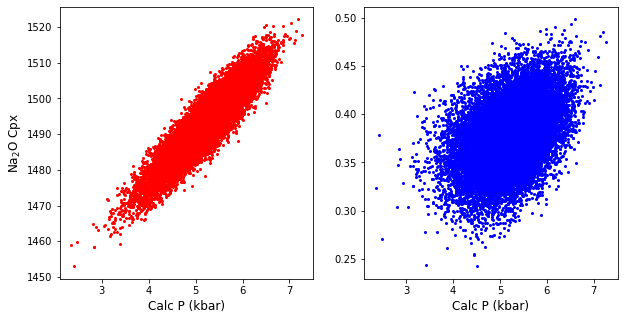

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(Calc_PT['P_Wang21_eq1'], Calc_PT['T_Wang21_eq2'], '.r' )
ax2.plot(Calc_PT['P_Wang21_eq1'], Calc_PT['Na2O_Cpx'], '.b' )
ax1.set_xlabel('Calc P (kbar)')
ax2.set_xlabel('Calc P (kbar)')
ax1.set_ylabel('Calc T (K)')
ax1.set_ylabel('Na$_2$O Cpx')


## A more robust way to show this
- If you play around with duplicates = , you'll see that the more points you ask for, the more spread in pressure space. 
- It is more robust to contour results
- First, we show how to do this using hexbin (matplotlib)
- We underlie the published error on the barometer, at the average calculated composition.

<ErrorbarContainer object of 3 artists>

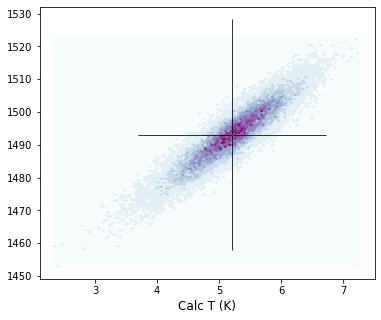

In [13]:
fig, (ax1)  = plt.subplots(1, 1, figsize=(6,5))

ax1.hexbin(Calc_PT['P_Wang21_eq1'],
           Calc_PT['T_Wang21_eq2'],
            cmap=plt.cm.BuPu, 
            linewidths=0.2, bins=10)
ax1.set_xlabel('Calc P (kbar)')
ax1.set_xlabel('Calc T (K)')


ax1.errorbar(np.mean(Calc_PT['P_Wang21_eq1']),
             np.mean(Calc_PT['T_Wang21_eq2']),
             xerr=1.52, yerr=35.2,
             fmt='.', ecolor='k', elinewidth=0.8, mfc='k', ms=1)

## But this is still hard to visualize!
- We can add contours using pyrolite, so we can visualize where 67% of simulations lie, and where 95% of simulations lie
- You will have to play around a bit with the number of bins, and the extent parameter.
- We always plot PT first, then use that to work out the extent, which tells the code where to look for contours in. This only needs to be approximate. 
- This step can be slow, if you are using 4-8 Gb of Ram, you might want to reduce the number of duplicates when you make the samples. 
- Remember to cite Pyrolite if you use these contours!

Text(0, 0.5, 'Calc T (K)')

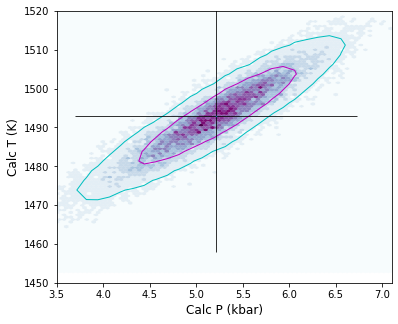

In [16]:
fig, (ax1)  = plt.subplots(1, 1, figsize=(6,5))

# This parameter helps pyrolite converge on the contour positions faster, 
# e.g. saying look for contours between 3.5 and 7 kbar
# and between 1470 and 1540 K. You'll need to change this for your particular system
extent1=(3.5, 7, 1470, 1540)
ax1.hexbin(Calc_PT['P_Wang21_eq1'],
           Calc_PT['T_Wang21_eq2'],
            cmap=plt.cm.BuPu, 
            linewidths=0.2, bins=10)
ax1.set_xlabel('Calc P (kbar)')
ax1.set_xlabel('Calc T (K)')


Calc_PT.loc[:, 
["P_Wang21_eq1", "T_Wang21_eq2"]].pyroplot.density(ax=ax1, contours=[0.67, 0.95], colors=['m', 'c'],
                                                   extent=extent1, cmap="viridis", 
                                                   bins=30, label_contours=False)
# Adjust axes limits
ax1.set_xlim([3.5, 7.1])
ax1.set_ylim([1450,  1520])

ax1.errorbar(np.mean(Calc_PT['P_Wang21_eq1']),
             np.mean(Calc_PT['T_Wang21_eq2']),
             xerr=1.52, yerr=35.2,
             fmt='.', ecolor='k', elinewidth=0.8, mfc='k', ms=1)

ax1.set_xlabel('Calc P (kbar)')
ax1.set_ylabel('Calc T (K)')

## Lets work out what would happen if we doubled the analytical error on Na2O
- Be patient, this takes a bit of time, its 20,000 calculations! 

In [19]:
# First, lets duplicate the error dataframe
df_Cpx_Err_2Na=df_Cpx_Err.copy()
# Lets set Na2O error to 2* what it was
df_Cpx_Err_2Na['Na2O_Cpx_Err']=2*df_Cpx_Err['Na2O_Cpx_Err']
# And lets take sample 0 again
Cpx_1_Err_2Na=df_Cpx_Err_2Na.iloc[[0]].reset_index(drop=True)
# Lets simulate some new Cpxs. 
Calc_Cpx_dist_2Na=pt.add_noise_sample_1phase(phase_comp=Cpx_1, phase_err=Cpx_1_Err_2Na,
                                             phase_err_type="Perc", duplicates=20000, err_dist="normal")
# And lets calculate pressures
Calc_PT_2Na=pt.calculate_cpx_only_press_all_eqs(cpx_comps=Calc_Cpx_dist_2Na)

All negative numbers replaced with zeros. If you wish to keep these, set positive=False


## Lets plot these new errors vs. the old errors
- Again, the contours can take ~30s to appear (with 16 Gb of RAM)

C:\Users\penny\anaconda3\lib\site-packages\pyrolite\util\plot\density.py:202: UserWarning: The following kwargs were not used by contour: 'width'
  cs = contour(


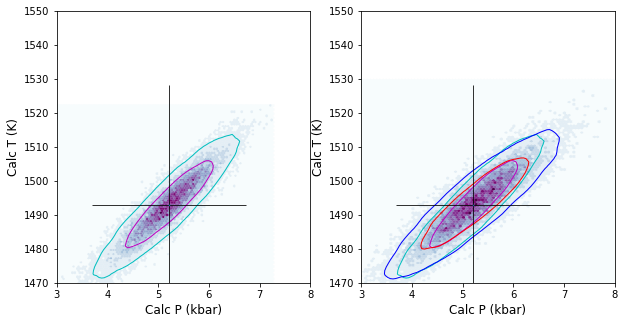

In [20]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)


extent1=(3.5, 7, 1470, 1540)
ax1.hexbin(Calc_PT['P_Wang21_eq1'],
           Calc_PT['T_Wang21_eq2'],
            cmap=plt.cm.BuPu, 
            linewidths=0.2, bins=10)
ax1.set_xlabel('Calc P (kbar)')
ax1.set_xlabel('Calc T (K)')




extent2=(3.5, 7, 1470, 1540)
ax2.hexbin(Calc_PT_2Na['P_Wang21_eq1'],
           Calc_PT_2Na['T_Wang21_eq2'],
            cmap=plt.cm.BuPu, 
            linewidths=0.2, bins=10)
ax2.set_xlabel('Calc P (kbar)')
ax2.set_xlabel('Calc T (K)')


Calc_PT.loc[:, 
["P_Wang21_eq1", "T_Wang21_eq2"]].pyroplot.density(ax=ax1, contours=[0.67, 0.95], colors=['m', 'c'],
                                                   extent=extent1, cmap="viridis", 
                                                   bins=70, label_contours=False)

Calc_PT.loc[:, 
["P_Wang21_eq1", "T_Wang21_eq2"]].pyroplot.density(ax=ax2, contours=[0.67, 0.95], colors=['m', 'c'],
                                                   extent=extent1, cmap="viridis", 
                                                   bins=70, label_contours=False, width=0.5)

Calc_PT_2Na.loc[:, 
["P_Wang21_eq1", "T_Wang21_eq2"]].pyroplot.density(ax=ax2, contours=[0.67, 0.95], colors=['r', 'blue'],
                                                   extent=extent2, cmap="viridis", 
                                                   bins=70, label_contours=False)

ax1.errorbar(np.mean(Calc_PT['P_Wang21_eq1']),
             np.mean(Calc_PT['T_Wang21_eq2']),
             xerr=1.52, yerr=35.2,
             fmt='.', ecolor='k', elinewidth=0.8, mfc='k', ms=1)

ax2.errorbar(np.mean(Calc_PT['P_Wang21_eq1']),
             np.mean(Calc_PT['T_Wang21_eq2']),
             xerr=1.52, yerr=35.2,
             fmt='.', ecolor='k', elinewidth=0.8, mfc='k', ms=1)

ax1.set_xlim([3, 8])
ax1.set_ylim([1470,  1550])

ax1.set_xlabel('Calc P (kbar)')
ax1.set_ylabel('Calc T (K)')

ax2.set_xlabel('Calc P (kbar)')
ax2.set_ylabel('Calc T (K)')
ax2.yaxis.set_tick_params(which='both', labelbottom=True)

## Lets make a pretty figure for publication with just the stated errors for Wang and Putirka thermobarometers, but overlay an additional contour for bigger Na2O errors

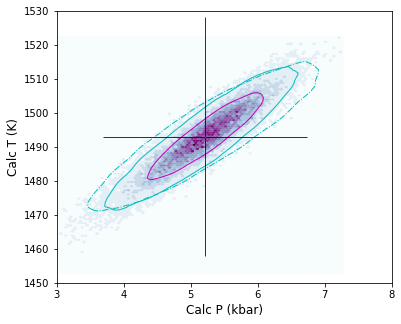

In [22]:
# Wang thermobarometers
fig, (ax1)  = plt.subplots(1, figsize=(6,5), sharex=True, sharey=True)

## LHS, Wang et al. 2021
extent1=(3.5, 7, 1470, 1540)
ax1.hexbin(Calc_PT['P_Wang21_eq1'],
           Calc_PT['T_Wang21_eq2'],
            cmap=plt.cm.BuPu, 
            linewidths=0.2, bins=10)
ax1.set_xlabel('Calc P (kbar)')
ax1.set_xlabel('Calc T (K)')


Calc_PT.loc[:, 
["P_Wang21_eq1", "T_Wang21_eq2"]].pyroplot.density(ax=ax1, contours=[0.67, 0.95], colors=['m', 'c'],
                                                   extent=extent1, cmap="viridis", 
                                                   bins=70, label_contours=False)


Calc_PT_2Na.loc[:, 
["P_Wang21_eq1", "T_Wang21_eq2"]].pyroplot.density(ax=ax1, contours=[0.95], colors=['c'],
                                                   extent=extent2, cmap="viridis", 
                                                   bins=70, label_contours=False,
                                                  linestyles=['-.'])

ax1.errorbar(np.mean(Calc_PT['P_Wang21_eq1']),
             np.mean(Calc_PT['T_Wang21_eq2']),
             xerr=1.52, yerr=35.2,
             fmt='.', ecolor='k', elinewidth=0.8, mfc='k', ms=1)


ax1.set_xlim([3, 8])
ax1.set_ylim([1450,  1530])

ax1.set_xlabel('Calc P (kbar)')
ax1.set_ylabel('Calc T (K)')

ax2.set_xlabel('Calc P (kbar)')
ax2.set_ylabel('Calc T (K)')

ax2.yaxis.set_tick_params(which='both', labelbottom=True)
fig.savefig('Cpx_only_Error.png', dpi=200)

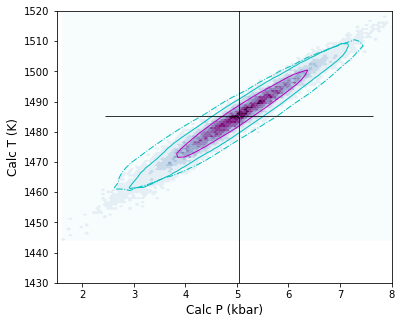

In [106]:
# Putirka Cpx-only barometers
fig, (ax1)  = plt.subplots(1, figsize=(6,5), sharex=True, sharey=True)

## LHS, Wang et al. 2021
extent1=(1, 10, 1430, 1540)
ax1.hexbin(Calc_PT['P_Put_Teq32d_Peq32b'],
           Calc_PT['T_Put_Teq32d_Peq32b'],
            cmap=plt.cm.BuPu, 
            linewidths=0.2, bins=10)
ax1.set_xlabel('Calc P (kbar)')
ax1.set_xlabel('Calc T (K)')


Calc_PT.loc[:, 
["P_Put_Teq32d_Peq32b", "T_Put_Teq32d_Peq32b"]].pyroplot.density(ax=ax1, contours=[0.67, 0.95], colors=['m', 'c'],
                                                   extent=extent1, cmap="viridis", 
                                                   bins=70, label_contours=False)

extent2=(1, 10, 1430, 1540)

Calc_PT_2Na.loc[:, 
["P_Put_Teq32d_Peq32b", "T_Put_Teq32d_Peq32b"]].pyroplot.density(ax=ax1, contours=[0.95], colors=['c'],
                                                   extent=extent2, cmap="viridis", 
                                                   bins=70, label_contours=False,
                                                  linestyles=['-.'])

ax1.errorbar(np.mean(Calc_PT['P_Put_Teq32d_Peq32b']),
             np.mean(Calc_PT['T_Put_Teq32d_Peq32b']),
             xerr=2.6, yerr=58,
             fmt='.', ecolor='k', elinewidth=0.8, mfc='k', ms=1)


ax1.set_xlim([1.5, 8])
ax1.set_ylim([1430,  1520])

ax1.set_xlabel('Calc P (kbar)')
ax1.set_ylabel('Calc T (K)')

ax2.set_xlabel('Calc P (kbar)')
ax2.set_ylabel('Calc T (K)')

ax2.yaxis.set_tick_params(which='both', labelbottom=True)
fig.savefig('Cpx_only_Error_Put.png', dpi=200)

### Lets calculate the statistics for various noise simulations

In [25]:
Stats_P=pt.av_noise_samples_series(Calc_PT['P_Wang21_eq1'], Calc_PT['Sample_ID_Cpx_Num'])
Stats_P

,Sample,Mean_calc,Median_calc,St_dev_calc,Max_calc,Min_calc
0,0.0,5.212426,5.237335,0.576768,7.262507,2.351651


In [26]:
Stats_T=pt.av_noise_samples_series(Calc_PT['T_Wang21_eq2'], Calc_PT['Sample_ID_Cpx_Num'])
Stats_T

,Sample,Mean_calc,Median_calc,St_dev_calc,Max_calc,Min_calc
0,0.0,1493.025062,1493.198869,8.540826,1522.1718,1452.932404


In [27]:
Stats_T=pt.av_noise_samples_series(Calc_PT_2Na['T_Wang21_eq2'], Calc_PT_2Na['Sample_ID_Cpx_Num'])
Stats_T

,Sample,Mean_calc,Median_calc,St_dev_calc,Max_calc,Min_calc
0,0.0,1493.363786,1493.548499,9.11549,1529.575166,1456.638437


In [28]:
Stats_P=pt.av_noise_samples_series(Calc_PT_2Na['P_Wang21_eq1'], Calc_PT_2Na['Sample_ID_Cpx_Num'])
Stats_P

,Sample,Mean_calc,Median_calc,St_dev_calc,Max_calc,Min_calc
0,0.0,5.2346,5.242048,0.714344,8.348103,2.126887


In [29]:
Stats_P_Put=pt.av_noise_samples_series(Calc_PT_2Na['P_Put_Teq32d_Peq32b'], Calc_PT_2Na['Sample_ID_Cpx_Num'])
Stats_P_Put

,Sample,Mean_calc,Median_calc,St_dev_calc,Max_calc,Min_calc
0,0.0,5.013051,5.022533,0.944134,8.845332,0.948181


In [30]:
Stats_P_Put=pt.av_noise_samples_series(Calc_PT['P_Put_Teq32d_Peq32b'], Calc_PT['Sample_ID_Cpx_Num'])
Stats_P_Put

,Sample,Mean_calc,Median_calc,St_dev_calc,Max_calc,Min_calc
0,0.0,5.019986,5.025435,0.83673,8.116579,1.594801


In [31]:
Stats_P_Put=pt.av_noise_samples_series(Calc_PT['T_Put_Teq32d_Peq32b'], Calc_PT['Sample_ID_Cpx_Num'])
Stats_P_Put

,Sample,Mean_calc,Median_calc,St_dev_calc,Max_calc,Min_calc
0,0.0,1485.050547,1485.152212,9.505677,1518.411815,1446.638034
